In [70]:
import numpy as np
import cv2
from skimage.util import img_as_float
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import scipy.io

height 1080.0
width 1920.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.001063823699951
(148, 36, 36, 6)


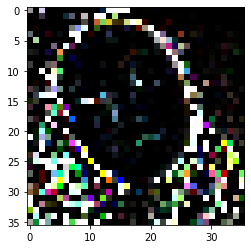

In [120]:
def DeepPhysPreprocessing(videoFilePath, dim):

    # load parameters
    start_time = time.time()
    dataURL = videoFilePath

    L = dim # 36
    t = []
    i = 0

    vidObj = cv2.VideoCapture(dataURL);   
    totalFrames = int(vidObj.get(cv2.CAP_PROP_FRAME_COUNT)) # get total frame size
    Xsub = np.zeros((totalFrames + 1, L, L, 3), dtype = np.float32)
    height = vidObj.get(cv2.CAP_PROP_FRAME_HEIGHT)
    width = vidObj.get(cv2.CAP_PROP_FRAME_WIDTH)

    print("height", height)
    print("width", width)
    
    success, img = vidObj.read()
    dims = img.shape

    while success:
        
        t.append(vidObj.get(cv2.CAP_PROP_POS_MSEC))# current timestamp in milisecond 
        time_cur = time.time()
        vidLxL = cv2.resize(img_as_float(img[:, int(width/2)-int(height/2 + 1):int(height/2)+int(width/2), :]), (L, L))
        vidLxL = cv2.rotate(vidLxL, cv2.ROTATE_90_CLOCKWISE) # rotate 90 degree
        vidLxL = cv2.cvtColor(vidLxL.astype('float32'), cv2.COLOR_BGR2RGB)
        vidLxL[vidLxL > 1] = 1
        vidLxL[vidLxL < (1/255)] = 1/255
        Xsub[i, :, :, :] = vidLxL
        success, img = vidObj.read() # read the next one
        i = i + 1
    
    time_cur = time.time()
    dXsub = np.zeros((len(t) - 1, L, L, 3), dtype = np.float32)
    for j in range(len(t) - 1):
        dXsub[j, :, :, :] = (Xsub[j+1, :, :, :] - Xsub[j, :, :, :]) / (Xsub[j+1, :, :, :] + Xsub[j, :, :, :])
    
    dXsub = dXsub / np.std(dXsub)
    Xsub = Xsub - np.mean(Xsub)
    Xsub = Xsub  / np.std(Xsub)

    Xsub = Xsub[1:totalFrames, :, :, :]
    plt.imshow(dXsub[30, :, :, :]) # Plot an example of data after preprocess
    dXsub = np.concatenate((dXsub, Xsub), axis = 3);
    print(time.time() - start_time)
    print(dXsub.shape)
    return dXsub
test = DeepPhysPreprocessing('./sample_video.mp4', 36)

In [118]:
import h5py
mat = np.transpose(np.array(h5py.File('nie.mat', 'r')["dXsub"]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


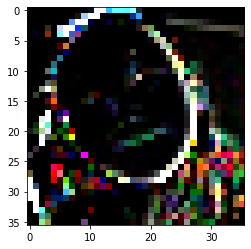

In [111]:
plt.imshow(mat[0, :, :, :3])